### Loading, Preprocessing of Data

In [1]:
# Loading cycles, hi_ga for all specimens, both L1 and L2
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.load_data import load_data

path = 'data'
filename = os.path.join(path, 'specimens_hi_ga.xlsx')
Xtrain, Ytrain, Xtest, Ytest, [train_specimens, test_specimens] = load_data(filename, threshold=0.845)
print(f'L1 specimens to be used for model training: {train_specimens}')
print(f'L2 specimens to be tested: {test_specimens}')

L1 specimens to be used for model training: ['ca_1', 'ca_2', 'ca_3', 'ca_4', 'va_1', 'va_2', 'va_3', 'va_4', 'va_5', 'sp_1', 'sp_2', 'sp_3', 'sp_4', 'sp_5', 'sp_7']
L2 specimens to be tested: ['L2-03', 'L2-04', 'L2-05', 'L2-07']


In [2]:
# Dynamic weights
from utils.dynamic_weigths import weight_calculation
weights = weight_calculation(Xtrain, Xtest)

print(f'Initial sequences length of train dataset: {[len(hi) for hi in Xtrain.values()]}')
print(f'Initial sequences length of test dataset: {[len(hi) for hi in Xtest.values()]}')
print(f'Weight size for test dataset: {[weights[test].shape for test in test_specimens]}')

Initial sequences length of train dataset: [494, 261, 239, 469, 409, 311, 436, 687, 485, 1593, 503, 1614, 1130, 835, 1639]
Initial sequences length of test dataset: [780, 370, 751, 389]
Weight size for test dataset: [(15, 780), (15, 370), (15, 751), (15, 389)]


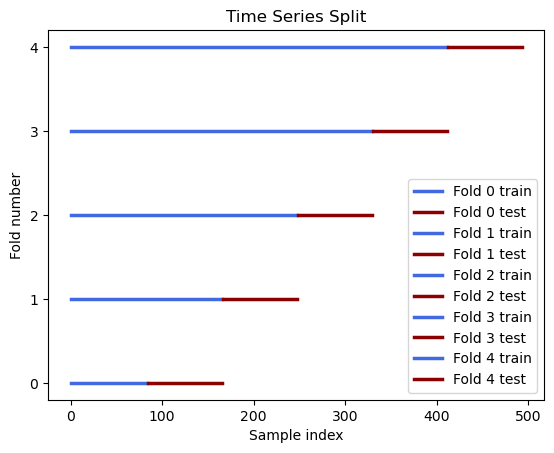

In [7]:
# Split Xtrain, Ytrain into training and validation sets for each specimen to perform time series cross validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
# Example of a single specimen
fig, ax = plt.subplots()
for i, (train, test) in enumerate(tscv.split(Xtrain['ca_1'])):
    ax.plot(train, [i]*len(train), label=f'Fold {i} train', color='royalblue', linewidth=2.5)
    ax.plot(test, [i]*len(test), label=f'Fold {i} test', color='darkred', linewidth=2.5)
ax.set_title('Time Series Split')
ax.set_yticks([0,1,2,3,4])
ax.set_ylabel('Fold number')
ax.set_xlabel('Sample index')
ax.legend()
plt.show()

### Bayesian Opt

In [ ]:
# Bayesian Optimization __ multiple models (skip this cell if you want to use the trained models)
from skopt import BayesSearchCV
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_squared_error
import pickle

scorer = make_scorer(mean_squared_error, greater_is_better=False)
svr_models = {}
for specimen in train_specimens:
    X = Xtrain[specimen].values.reshape(-1,1)
    y = Ytrain[specimen]
    
    # Search space
    param_grid = {'C': (1e+1, 1e+4, 'log-uniform'),
                'gamma': (1e-1, 1e+0, 'log-uniform')}
    svr = SVR(kernel='rbf')
    
    # Perform hyperparameter tuning
    opt = BayesSearchCV(svr, param_grid, n_iter=20, scoring=scorer, cv=tscv, n_jobs=-1, verbose=0)
    opt.fit(X, y)
    print("Best parameters found: ", opt.best_params_)
    print("Best mean squared error: ", -opt.best_score_)
    
    # Train the model with the best hyperparameters on the entire data set
    svr = SVR(kernel='rbf', C=opt.best_params_['C'], gamma=opt.best_params_['gamma'])
    svr.fit(X, y)

    svr_models[specimen] = svr
    predicted_rul = svr.predict(X)
    # Plot true vs predicted RUL
    plt.plot(y, label='True')
    plt.plot(predicted_rul, label='Predicted')
    plt.legend()
    plt.show()

# Save the models
path = 'models'
filename = os.path.join(path, 'svr_models.pkl')
with open(filename, 'wb') as f:
    pickle.dump(svr_models, f)

In [4]:
# Load the trained SVR models
import pickle

path = 'models'
filename = os.path.join(path, 'svr_models.pkl')
with open(filename, 'rb') as f:
    svr_models = pickle.load(f)

### Results for a single specimen

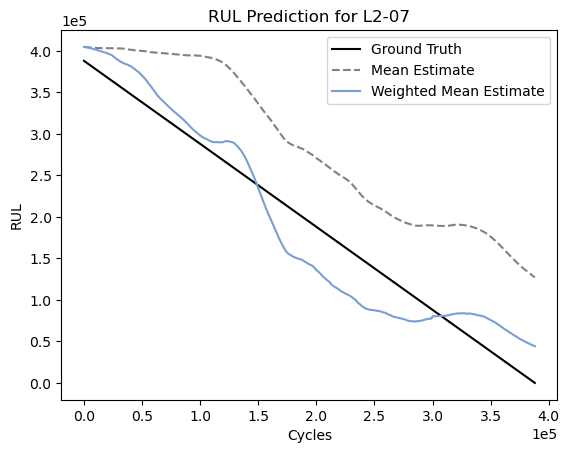

In [6]:
# Select a single test specimen
specimen = 'L2-07'
Xt = Xtest[specimen].values.reshape(-1,1)
yt = Ytest[specimen]
cycles = yt[::-1]

# Ensemble prediction
predicted_rul = [svr_models[specimen].predict(Xt) for specimen in train_specimens]
## Weighted average 
weighted_rul = [weights[specimen][i] * predicted_rul[i] for i, _ in enumerate(train_specimens)]

# Plot true vs predicted RUL for both weighted and unweighted predictions
fig, ax = plt.subplots()
ax.plot(cycles, yt, label='Ground Truth', color='black')
ax.plot(cycles, np.mean(predicted_rul, axis=0), '--', label='Mean Estimate', color='#808183')
ax.plot(cycles, np.mean(weighted_rul, axis=0), label='Weighted Mean Estimate', color='#799ed3')
ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 0))
ax.set_title(f'RUL Prediction for {specimen}')
ax.set_xlabel('Cycles')
ax.set_ylabel('RUL')
ax.legend()
plt.show()

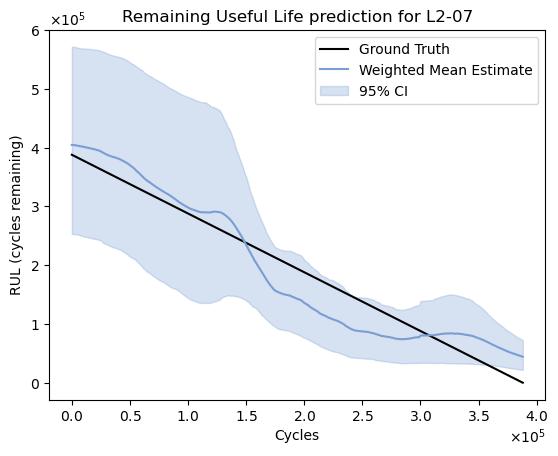

In [10]:
from utils.figures import plot_predictions
fig, lower, upper = plot_predictions(yt, weighted_rul, specimen)